In [112]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet arviz bambi preliz kulprit)"

In [1]:
#!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-code-formatter black yapf autopep8 isort)"
#!jupyter labextension enable

In [2]:
%load_ext autoreload
%autoreload 2

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

print("pymc.version=", pm.__version__)
print("arviz.version=", az.__version__)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc.version= 5.16.2
arviz.version= 0.19.0


In [3]:
import bambi as bmb
import preliz as pz

In [127]:
plt.rcParams["figure.figsize"] = [8, 3]

dir_name = "/aux/code/book.2018.Martin.Bayesian_Analysis_with_Python.2e"

## One syntax to rule them all

In [5]:
# Create a dataframe of 117 rows with 3 random (gaussian) variable and 3 groups
# (each with 39 values).
SIZE = 117
np.random.seed(42)
data = pd.DataFrame(
    {
        "y": np.random.normal(size=SIZE),
        "x": np.random.normal(size=SIZE),
        "z": np.random.normal(size=SIZE),
        "g": ["Group A", "Group B", "Group C"] * 39,
    }
)
data.head()

,y,x,z,g
0,0.496714,-1.168678,2.143944,Group A
1,-0.138264,1.142823,0.633919,Group B
2,0.647689,0.751933,-2.025143,Group C
3,1.523030,0.791032,0.186454,Group A
4,-0.234153,-0.909387,-0.661786,Group B


In [14]:
a_model = bmb.Model("y ~ x", data)
a_model

       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.0874, sigma: 2.3002)
            x ~ Normal(mu: 0.0, sigma: 2.3146)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.9176)

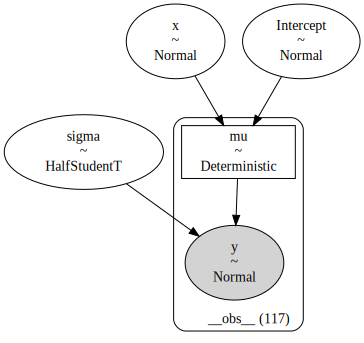

In [15]:
a_model.build()
a_model.graph()

In [8]:
# Model with custom priors.
priors = {
    "x": bmb.Prior("HalfNormal", sigma=3),
    "sigma": bmb.Prior("Gamma", mu=1, sigma=2),
}
a_model_wcp = bmb.Model("y ~ x", data, priors=priors)
a_model_wcp

       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.0874, sigma: 2.294)
            x ~ HalfNormal(sigma: 3.0)
        
        Auxiliary parameters
            sigma ~ Gamma(mu: 1.0, sigma: 2.0)

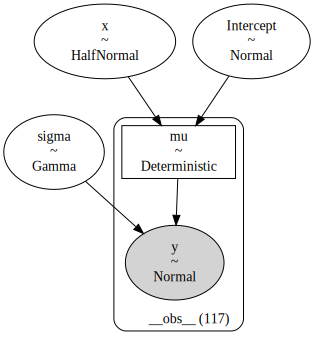

In [17]:
a_model_wcp.build()
a_model_wcp.graph()

In [18]:
model_h = bmb.Model("y ~ x + z + (x | g)", data)
model_h

       Formula: y ~ x + z + (x | g)
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.0874, sigma: 2.3005)
            x ~ Normal(mu: 0.0, sigma: 2.3146)
            z ~ Normal(mu: 0.0, sigma: 2.4316)
        
        Group-level effects
            1|g ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.3005))
            x|g ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.3146))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.9176)

## Bikes

In [27]:
bikes = pd.read_csv(dir_name + "/data2/bikes.csv")
bikes.head()

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0


In [28]:
model_t = bmb.Model("rented ~ temperature", bikes, family="negativebinomial")
idata_t = model_t.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, temperature]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.9184)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [30]:
model_t

       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.9184)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

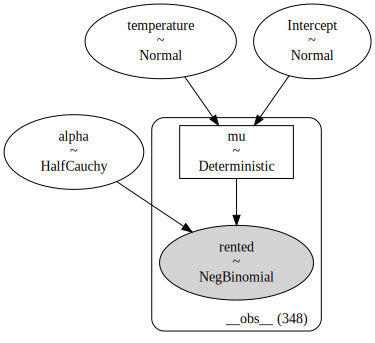

In [29]:
model_t.graph()

Sampling: [Intercept, alpha, temperature]


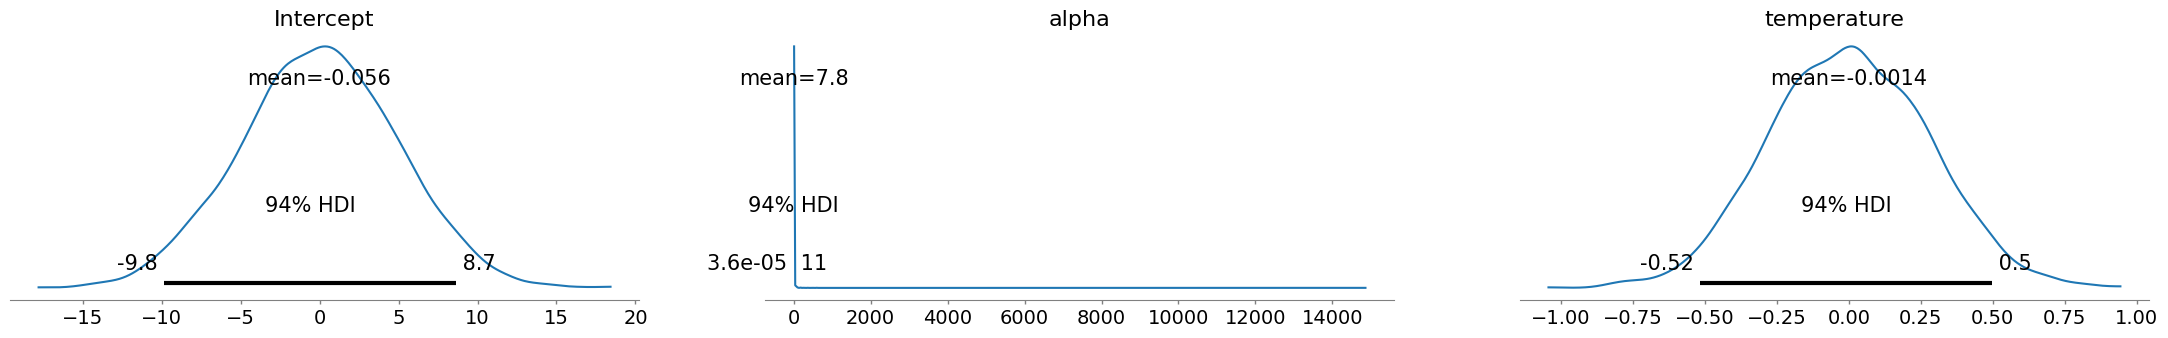

In [32]:
model_t.plot_priors();

In [34]:
az.summary(idata_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.437,0.114,4.227,4.646,0.002,0.001,5640.0,3414.0,1.0
alpha,0.960,0.066,0.834,1.082,0.001,0.001,5717.0,3203.0,1.0
temperature,0.048,0.006,0.036,0.060,0.000,0.000,5508.0,3457.0,1.0


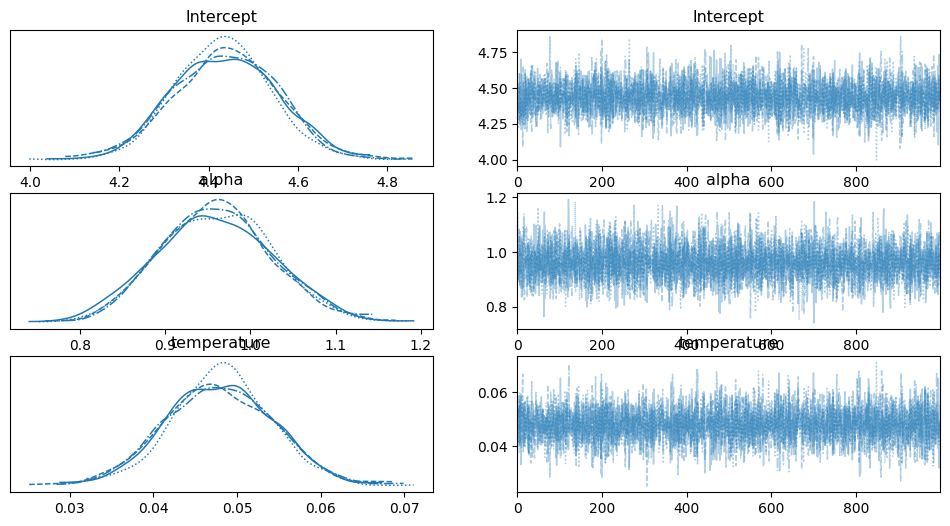

In [36]:
az.plot_trace(idata_t);

/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: temperature


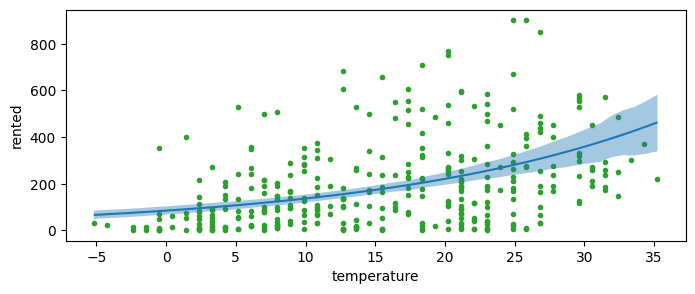

In [54]:
# Plot the posterior mean.
_, ax = plt.subplots(1, 1)
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
bmb.interpret.plot_predictions(model_t, idata_t, "temperature", ax=ax);

- It accounts for the uncertainty of the intercept and the slope

/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: temperature


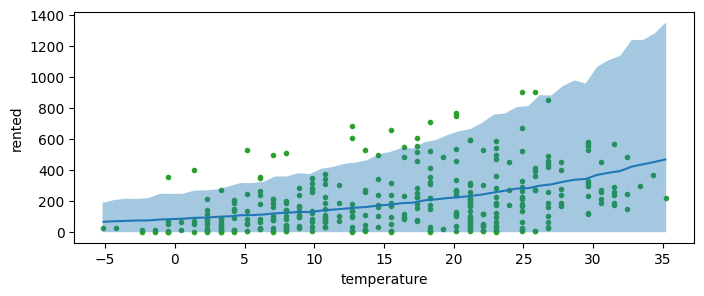

In [56]:
# Plot predictions.
_, ax = plt.subplots(1, 1)
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
bmb.interpret.plot_predictions(model_t, idata_t, "temperature", pps=True, ax=ax);

- It accounts for the uncertainty in all the model parameters

## Using more independent variables.

In [70]:
# model_th = bmb.Model("rented ~ temperature + humidity", bikes, family="negativebinomial")
model_th = bmb.Model("rented ~ humidity", bikes, family="negativebinomial")
idata_th = model_th.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, humidity]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [72]:
az.summary(idata_th)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.423,0.210,6.021,6.807,0.003,0.002,6160.0,3184.0,1.0
alpha,0.925,0.062,0.814,1.045,0.001,0.001,5225.0,3246.0,1.0
humidity,-1.938,0.322,-2.563,-1.348,0.004,0.003,6220.0,3386.0,1.0


In [79]:
# bmb.interpret.plot_predictions(model_th, idata_th,
#                                ["temperature", "humidity"],
#                                subplot_kwargs={"group":None, "panel":"humidity"},
#                                legend=False,
#                                fig_kwargs={"sharey":True, "sharex":True});

In [81]:
# help(bmb.interpret.plot_predictions)

## Polynomial regression

In [82]:
model_poly_1 = bmb.Model("rented ~ hour", bikes, family="negativebinomial")
idata_poly_1 = model_poly_1.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, hour]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [84]:
az.summary(idata_poly_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.065,0.125,3.832,4.300,0.002,0.001,5787.0,2987.0,1.0
alpha,1.022,0.070,0.892,1.154,0.001,0.001,6191.0,3054.0,1.0
hour,0.093,0.010,0.075,0.113,0.000,0.000,5516.0,2677.0,1.0


In [85]:
model_poly_4 = bmb.Model("rented ~ poly(hour, 4)", bikes, family="negativebinomial")
idata_poly_4 = model_poly_4.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, poly(hour, 4)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [86]:
az.summary(idata_poly_4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.982,0.044,4.901,5.069,0.001,0.000,5554.0,3478.0,1.0
alpha,1.384,0.098,1.204,1.566,0.001,0.001,5026.0,3358.0,1.0
"poly(hour, 4)[0]",11.856,0.911,10.196,13.583,0.013,0.009,4704.0,3416.0,1.0
"poly(hour, 4)[1]",-10.918,0.882,-12.624,-9.306,0.013,0.009,4591.0,3550.0,1.0
"poly(hour, 4)[2]",-3.885,0.847,-5.466,-2.274,0.012,0.009,4663.0,3305.0,1.0
"poly(hour, 4)[3]",3.280,0.946,1.494,5.021,0.013,0.009,5038.0,3336.0,1.0


# Categorical predictors

In [89]:
penguins = pd.read_csv(dir_name + "/data2/penguins.csv").dropna()
penguins.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


In [96]:
def grouped_plot(var_name):
    # Get unique categories
    unique_categories = np.unique(penguins[var_name])

    # Create color map for categories
    category_color_map = {cat: f"C{i}" for i, cat in enumerate(unique_categories)}

    # Generate colors for each category
    colors = [category_color_map[cat] for cat in penguins[var_name]]

    # Create scatter plot for each category
    for cat in unique_categories:
        category_data = penguins[penguins[var_name] == cat]
        plt.scatter(
            category_data.body_mass,
            category_data.bill_length,
            c=category_color_map[cat],
            label=cat,
        )
    plt.legend(labels=unique_categories, loc="lower right")

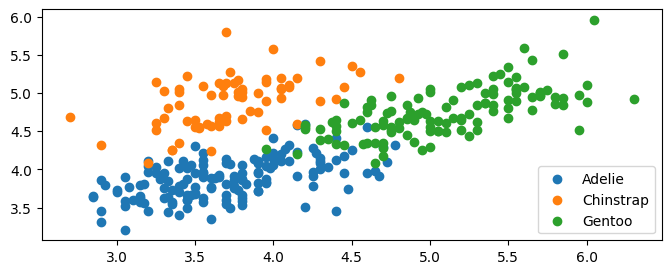

In [97]:
grouped_plot("species")

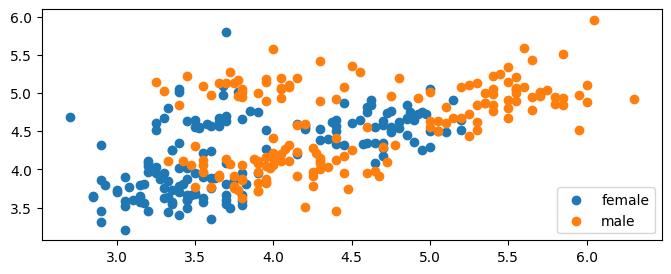

In [98]:
grouped_plot("sex")

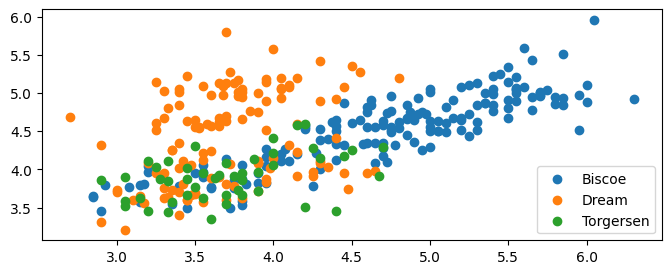

In [99]:
grouped_plot("island")

In [100]:
model_p = bmb.Model("body_mass ~ bill_length + species", data=penguins)
idata_p = model_p.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, bill_length, species]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [101]:
az.summary(idata_p)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.213,0.274,-0.324,0.704,0.006,0.004,2050.0,2411.0,1.0
bill_length,0.900,0.070,0.768,1.031,0.002,0.001,1930.0,2260.0,1.0
sigma,0.376,0.014,0.350,0.403,0.000,0.000,3655.0,2682.0,1.0
species[Chinstrap],-0.874,0.090,-1.042,-0.707,0.002,0.001,2013.0,2565.0,1.0
species[Gentoo],0.600,0.076,0.462,0.747,0.002,0.001,1911.0,2334.0,1.0


/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: bill_length, species


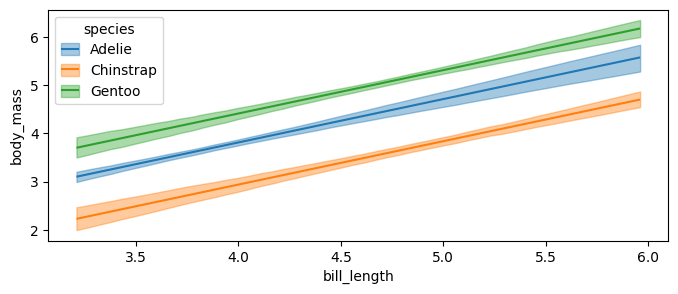

In [103]:
bmb.interpret.plot_predictions(model_p, idata_p, ["bill_length", "species"]);

# Interaction

In [120]:
# No interaction
model_noint = bmb.Model("body_mass ~ bill_depth + bill_length", data=penguins)
idata_noint = model_noint.fit()

# Interaction
model_int = bmb.Model(
    "body_mass ~ bill_depth + bill_length + bill_depth:bill_length", data=penguins
)
idata_int = model_int.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, bill_depth, bill_length]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, bill_depth, bill_length, bill_depth:bill_length]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [110]:
comparison = az.compare(
    {"model_noint": idata_noint, "model_int": idata_noint}, ic="waic"
)

TypeError: Encountered error in ELPD computation of compare.

# Interpreting models with Bambi

/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 800x300 with 1 Axes>,
 array([<Axes: xlabel='bill_length', ylabel='body_mass'>], dtype=object))

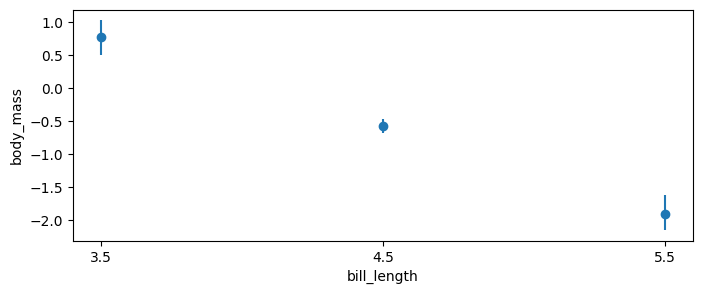

In [107]:
bmb.interpret.plot_comparisons(
    model_int,
    idata_int,
    contrast={"bill_depth": [1.4, 1.8]},
    conditional={"bill_length": [3.5, 4.5, 5.5]},
)

# Variable selection with Kulprit

In [113]:
import kulprit as kpt

In [116]:
body = pd.read_csv(dir_name + "/data2/body_fat.csv")
body.head()

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7


In [117]:
model = bmb.Model("siri ~ age + weight + height + abdomen + thigh + wrist", data=body)
idata = model.fit(idata_kwargs={"log_likelihood": True}, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, weight, height, abdomen, thigh, wrist]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [122]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [123]:
ppi = kpt.ProjectionPredictive(model, idata)
ppi.search()
ppi

  0 siri ~ 1
  1 siri ~ abdomen
  2 siri ~ abdomen + weight
  3 siri ~ abdomen + weight + wrist
  4 siri ~ abdomen + weight + wrist + age
  5 siri ~ abdomen + weight + wrist + age + height
  6 siri ~ abdomen + weight + wrist + age + height + thigh

In [125]:
submodel = ppi.project(3)
print(submodel)
print(type(submodel))

siri ~ abdomen + weight + wrist
<class 'kulprit.data.submodel.SubModel'>


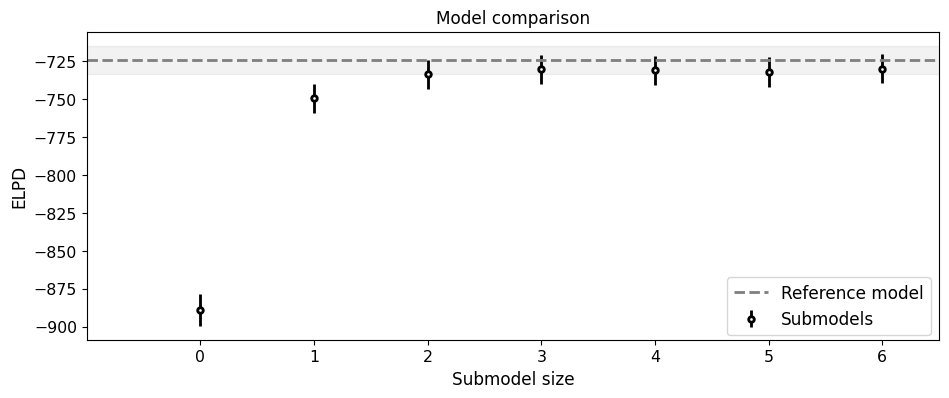

In [128]:
cmp, ax = ppi.plot_compare(plot=True, figsize=(11, 4))